In [72]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    # "tensorflow", # for open ai pretrained wights
]

for p in pkgs:
    print(f"{p}: {version(p)}")

import torch

torch.set_printoptions(
    sci_mode=False,      # Turn off scientific notation
    precision=4,         # Number of decimal places
    threshold=100,      # Number of elements to print before summarizing
    linewidth=120        # Characters per line before wrapping
)


matplotlib: 3.10.5
numpy: 2.3.2
tiktoken: 0.9.0
torch: 2.2.2


In [2]:
from gpt_helpers import GPTModel

GPT_CONFIG_124M = {
    'vocab_size': 50257,  # vocab size
    'context_length': 256,  # context length
    'emb_dim': 768,  # embedding dimension
    'n_layers': 12,  # number of transformer blocks
    'n_heads': 12,  # number of attention heads
    'drop_rate': 0.1,  # dropout rate
    'qkv_bias': False,  # whether to use bias in the query, key, and value weights
}

In [3]:


torch.manual_seed(456)

model = GPTModel(GPT_CONFIG_124M)
# model.eval()    # this shows the model architecture
model.eval();


In [4]:
import tiktoken
from gpt_helpers import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  #adding batch dimension for the current architecture
    return encoded_tensor




In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)
print(token_ids)

tensor([[6109, 3626, 6100,  345]])


In [6]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you


In [7]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print(token_ids.squeeze(0))

tensor([ 6109,  3626,  6100,   345, 13443, 37191, 25420, 23390, 35735, 37542, 27518, 24287, 31523,  8074])


In [8]:
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you vague trousers deepest cyclistsurnal rpm discourage northeast breaches Hom


In [9]:
print(token_ids[0, :5])

tensor([ 6109,  3626,  6100,   345, 13443])


# 5.1.2 calculating the text generation loss: Cross entropy  and perplexity

In [10]:
print(text_to_token_ids("every effort moves", tokenizer))
print(text_to_token_ids("I really like", tokenizer))
print(text_to_token_ids(" effort moves you", tokenizer))
print(text_to_token_ids(" really like chocolate", tokenizer))

tensor([[16833,  3626,  6100]])
tensor([[  40, 1107,  588]])
tensor([[3626, 6100,  345]])
tensor([[ 1107,   588, 11311]])


In [11]:
# lets look at some example of logits

inputs = torch.tensor([[16833, 3626, 6100],
                       [40, 1107, 588]])

targets = torch.tensor([[3626, 6100, 345],
                        [1107, 588, 11311]])



In [12]:
with torch.no_grad():
    logits = model(inputs)

print(logits.shape)


torch.Size([2, 3, 50257])


In [13]:
probas = torch.softmax(logits, dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [14]:
probas

tensor([[[    0.0000,     0.0001,     0.0001,  ...,     0.0000,     0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,     0.0000],
         [    0.0000,     0.0001,     0.0000,  ...,     0.0000,     0.0000,     0.0000]],

        [[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0001,  ...,     0.0000,     0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,     0.0000]]])

In [15]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)
# token_ids_to_text(preds, tokenizer)

Token IDs:
 tensor([[[ 5365],
         [13774],
         [30197]],

        [[41229],
         [31634],
         [ 7710]]])


In [16]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"ouputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
ouputs batch 1:  relatively crying Northwestern


In [17]:
# targets[txt_idx]

In [18]:
# what iss the probability of the target token for the target ( actually what it should have been )
txt_idx = 0
target_probas1 = probas[txt_idx, [0, 1, 2], targets[txt_idx]]
print("text 1:", target_probas1)
# ideally we want to increase the above probability score during training

text 1: tensor([    0.0000,     0.0001,     0.0000])


In [19]:
# what iss the probability of the target token for the target ( actually what it should have been )
txt_idx = 1
target_probas2 = probas[txt_idx, [0, 1, 2], targets[txt_idx]]
print("text 2:", target_probas2)

text 2: tensor([    0.0000,     0.0000,     0.0000])


In [20]:
# whats the error?
# compute the log probabilities
log_probas = torch.log(torch.cat((target_probas1, target_probas2)))
print(log_probas)

tensor([-10.5025,  -9.6969, -11.0536, -10.3832, -10.6481, -11.6515])


In [21]:
# negative log likelihood
-1 * torch.mean(log_probas)
# the idea is to make this close to zero

tensor(10.6560)

In [22]:
print(torch.log(torch.tensor([1.0])))
print(torch.log(torch.tensor([0.00000000000003])))

tensor([0.])
tensor([-31.1376])


In [23]:
logits.shape

torch.Size([2, 3, 50257])

In [24]:
logits_flat = logits.flatten(0, 1)
logits_flat.shape

torch.Size([6, 50257])

In [25]:
targets_flat = targets.flatten(0, 1)
targets_flat.shape

torch.Size([6])

In [26]:
targets_flat = targets.flatten(0, 1)
targets_flat.shape


torch.Size([6])

In [27]:
# pytorch shortcut

torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.6560)

# Calculating the loss

In [28]:
import os
import urllib.request

with open('docs/the-verdict.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

In [29]:
raw_text[:100]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g'

In [30]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))

print(f"Total Characters: {total_characters}")
print(f"Total Tokens: {total_tokens}")

Total Characters: 20479
Total Tokens: 5145


In [31]:
# split the data to training set and validation set

from gpt_helpers import create_dataloaderV1

# Train/Validation ratio
train_ratio = 0.90
split_idx = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]


In [32]:
torch.manual_seed(123)

train_loader = create_dataloaderV1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloaderV1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)



In [33]:
print("Train loader")

for x, y in train_loader:
    pass
print(x.shape, y.shape)

Train loader
torch.Size([2, 256]) torch.Size([2, 256])


In [34]:
print("Validation loader")

for x, y in val_loader:
    pass
print(x.shape, y.shape)

Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [35]:
x.numel()

512

In [36]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("train tokens:", train_tokens)
print("val tokens:", val_tokens)
print("all tokens:", train_tokens + val_tokens)

train tokens: 4608
val tokens: 512
all tokens: 5120


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [38]:
len(train_loader)

9

In [39]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the dataloader
        # if num_batches excceds the number of batches in  the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches



In [40]:
# for reproducability due to thee shuffling in the dataloader
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

train loss: 10.9898, val loss: 10.9956


#  Perplexity

In [41]:
# perplexity score, it basically says how unsure the model is about the words it predicts
torch.exp(torch.tensor(train_loss))

tensor(59267.2891)

# training the LLM

In [42]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [43]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

In [44]:
num_epochs = 10
train_losses, val_losses, token_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

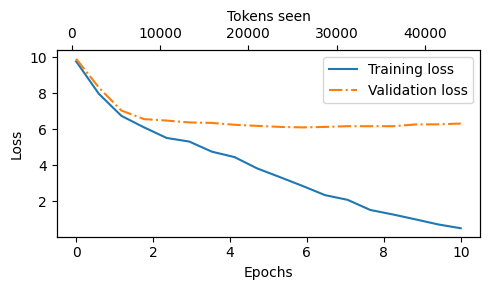

In [45]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen.tolist(), train_losses, label="Training loss")
    ax1.plot(epochs_seen.tolist(), val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

# Decoding strategies to control randomness

In [46]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




# Temperature scaling

In [47]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "towards": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'towards',
 8: 'you'}

In [48]:
# We usually do get the next token i.e the logits
# logits = model(x)

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
probas


tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,     0.0001,     0.3576,     0.0040])

In [49]:
probas.sum()

tensor(1.0000)

In [50]:
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [51]:
# this would be generated when we use the generate_text_simple function
inverse_vocab[next_token_id]

'forward'

In [52]:
# instead of deterministic we can use torch multinomial lets us sample from these probabilities .
# so instead of deterministically always getting the largest token we will now get the token proportional to these probas
# or proportional to the probability values.

# torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

towards


In [53]:
def print_sampled_token(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i,freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_token(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x towards
4 x you


In [54]:
10/0.98, 10.0/3

(10.204081632653061, 3.3333333333333335)

In [56]:
def softmax_with_temperature(logits, temp):
    scaled_logits = logits / temp
    return torch.softmax(scaled_logits, dim=0)

softmax_with_temperature(next_token_logits, 2)

tensor([0.1375, 0.0225, 0.0056, 0.4214, 0.0326, 0.0064, 0.0056, 0.3331, 0.0353])

In [57]:
test_temps = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in test_temps]

In [58]:
scaled_probas[0].detach().cpu()#.tolist()

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,     0.0001,     0.3576,     0.0040])

In [59]:
import numpy as np

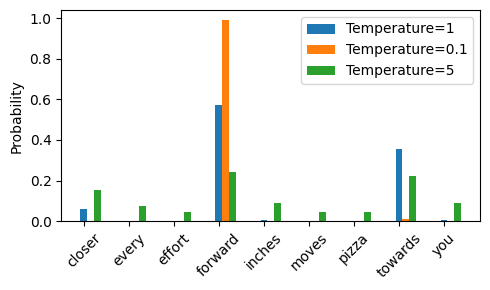

In [60]:
# plotting

x = list(range(len(vocab)))
x = np.array(x)
bar_width  = 0.15

fig,ax = plt.subplots(figsize=(5,3))
for i,T in enumerate(test_temps):
    rects = ax.bar(x+i*bar_width,scaled_probas[i].tolist(), width=bar_width, label=f"Temperature={T}")

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=45)
ax.legend()

plt.tight_layout()
# plt.savefig("temp-plot.pdf")
plt.show()

In [61]:
scaled_probas[2].sum()

tensor(1.0000)

# top K sampling

This selects the top K highest logits

In [62]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [63]:
top_k = 3
top_logits, top_pos  = torch.topk(next_token_logits, k=top_k)
print(top_logits)
print(top_pos)

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [64]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [65]:
torch.softmax(new_logits, dim=0)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

# modifying the generate text function

In [66]:
tokenizer.decode([50256])

'<|endoftext|>'

In [67]:
def generate_text(model, idx, max_new_tokens=100, context_size=1024, temperature=0.0, top_k=None, eos_id=None):
    # idx is (Batch, Token) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the context size limit
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then the last 5 tokenes are used
        idx_cond = idx[:, -context_size:]

        # get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch , n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, top_pos  = torch.topk(logits, k=top_k)
            new_logits = torch.where(
                condition=logits < top_logits[:, -1],
                input=torch.tensor(float("-inf")),
                other=logits
            )

        if temperature > 0.0:
            probas = torch.softmax(logits / temperature, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            # get the idx of the vocab enty with the highest logits value
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=-1)

    return idx

In [68]:
torch.manual_seed(123)

token_ids = generate_text(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length'],
    # temperature=1.4,
    # top_k=25,

)

print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [69]:
token_ids = generate_text(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length'],
    temperature=1.4,
    top_k=25,

)

print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 Every effort moves you Bernsteinuskicolds a sore furiouslyorg itbred the Avees-- XVelling of jealousyating ale SE Dy to hot matte


# loading and saving model weights in pytorch

In [71]:
torch.save(model.state_dict(), 'model_weights.pth')